In [2]:
from IPython.display import display, HTML, Markdown
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn
import pandas as pd
from scipy.interpolate import CubicSpline
# pip install scikit-learn statsmodels
from sklearn.linear_model import LinearRegression
import graphviz
import numpy as np

Sortir d'un capteur
===================

- Type de sortie statique ou dynamique
- Bruit
- Identification d'une courbe affine
- Linéarisation



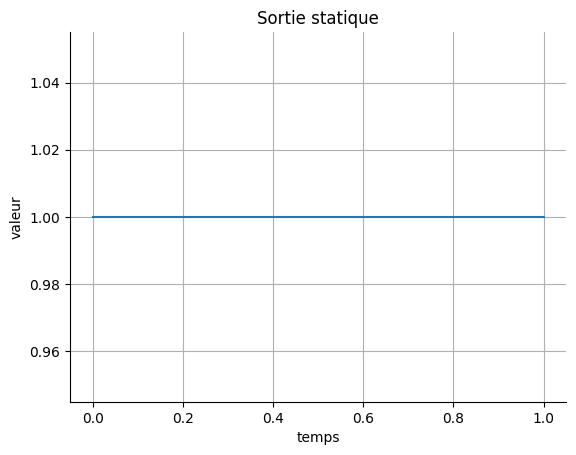

In [25]:

fig, ax = plt.subplots()
ax.plot([0, 1],np.array([1, 1])*1)
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie statique")
ax.grid(True, which='both')

seaborn.despine(ax=ax, offset=0)

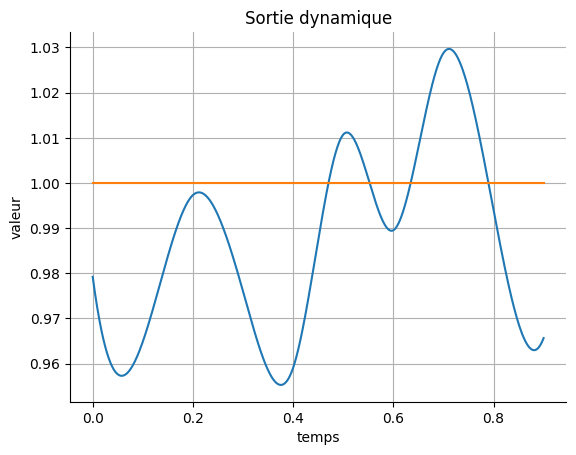

In [19]:
# Génération de données aléatoires, lissage avec une Spline
a=np.arange(0,1,0.1)

def someSignal(a, N=1000, A=0.1, O=1):
    a_interp = np.linspace(a[0], a[-1], N)
    b=(np.random.rand(len(a))-0.5)*A+O
    spl = CubicSpline(a,b)
    b_interp = spl(a_interp)
    return a_interp, b_interp

a_interp, b_interp = someSignal(a,1000)

fig, ax = plt.subplots()
ax.plot(a_interp,b_interp)
ax.plot(a, np.ones(len(a)))
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie dynamique")
ax.grid(True, which='both')

seaborn.despine(ax=ax, offset=0)

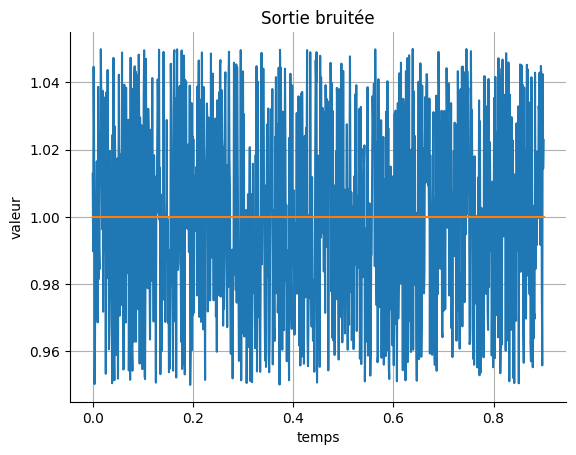

In [7]:

a_lot = np.linspace(a[0], a[-1], 1000)
b_lot =(np.random.rand(len(a_lot))-0.5)*0.1+1

fig, ax = plt.subplots()
ax.plot(a_lot,b_lot)
ax.plot(a, np.ones(len(a)))
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie bruitée")
ax.grid(True, which='both')

seaborn.despine(ax=ax, offset=0)

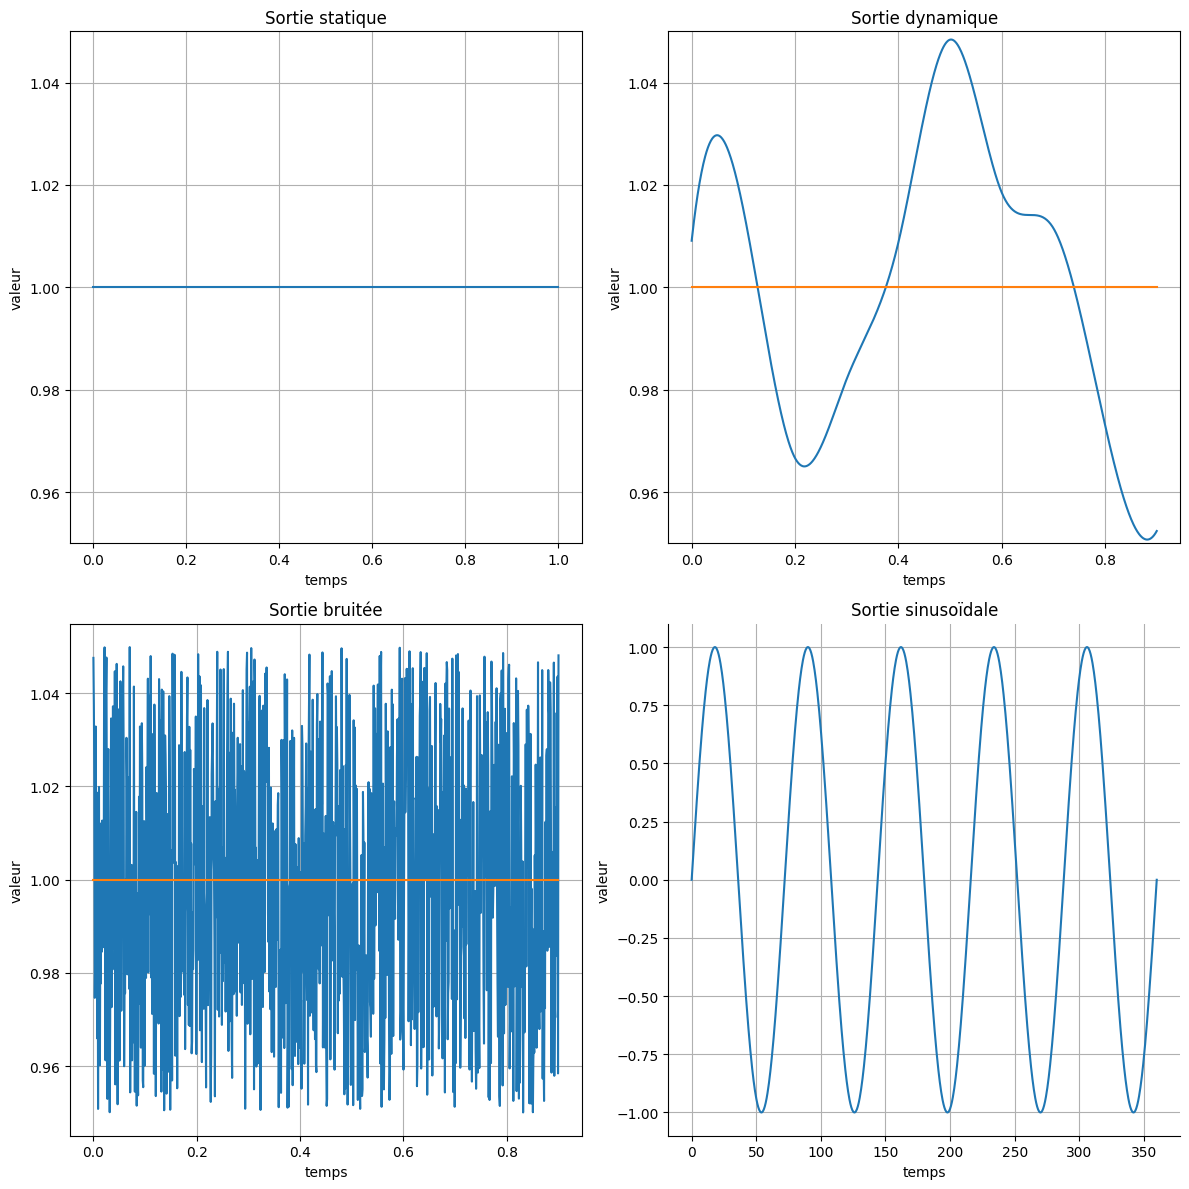

In [8]:
#| label: fig-signal-types
f = plt.figure(figsize=(12, 12))
gs = f.add_gridspec(2, 2)


ax = f.add_subplot(gs[0, 0])
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie statique")
ax.grid(True, which='both')
plt.ylim([0.95, 1.05])
plt.plot([0, 1],[1, 1])

ax = f.add_subplot(gs[0, 1])
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie dynamique")
ax.grid(True, which='both')
plt.ylim([0.95, 1.05])
ax.plot(a_interp,b_interp)
ax.plot(a, np.ones(len(a)))

a_lot = np.linspace(a[0], a[-1], 1000)
b_lot =(np.random.rand(len(a_lot))-0.5)*0.1+1

ax = f.add_subplot(gs[1, 0])
ax.plot(a_lot,b_lot)
ax.plot(a, np.ones(len(a)))
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie bruitée")
ax.grid(True, which='both')

# Sinus
a_time = np.linspace(0, 360, 1000)
b_sin =np.sin(a_time/360*np.pi*10)

ax = f.add_subplot(gs[1, 1])
ax.plot(a_time,b_sin)
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie sinusoïdale")
ax.grid(True, which='both')
seaborn.despine(ax=ax, offset=0)
f.tight_layout()

### Signal résultant

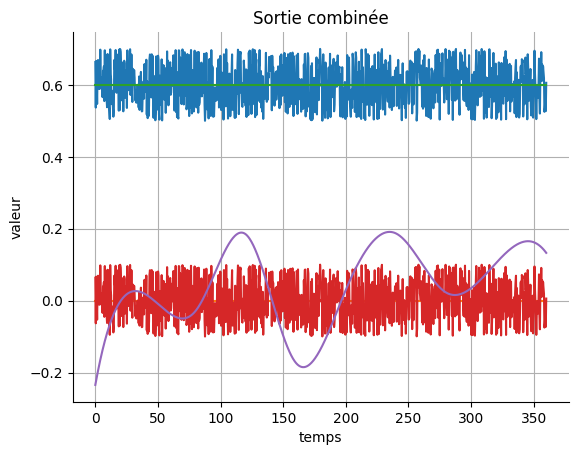

In [29]:
#| label: fig-signal-types-resultant
a_time = np.linspace(0, 360, 1000)
b_sin =np.sin(a_time/360*np.pi*30)*0.0
c_cst = np.ones(len(a_time))*0.6
d_noise = (np.random.rand(len(a_lot))-0.5)*0.2
tmp,e_dyn = someSignal(a, len(a_time), A=0.5, O=0)

resultant = b_sin+c_cst+d_noise+e_dyn*0
fig, ax = plt.subplots()
ax.plot(a_time,resultant)
ax.plot(a_time, b_sin)
ax.plot(a_time, c_cst)
ax.plot(a_time, d_noise)
ax.plot(a_time, e_dyn)
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Sortie combinée")
ax.grid(True, which='both')
#fig.set_legend(["a","b"])
seaborn.despine(ax=ax, offset=0)

Temps de réponse

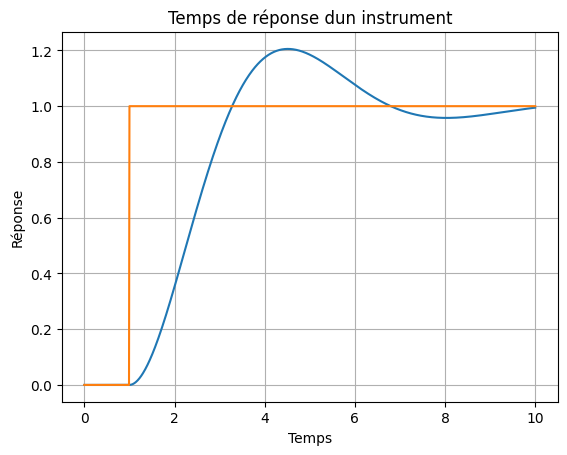

In [13]:
#| label: fig-temps-de-reponse
#| fig-cap: "La réponse à un change de valeur de la mesurande (en rouge) prend un certain temps à se stabiliser (courbe en bleu)"
import numpy as np
import matplotlib.pyplot as plt
import control

# Define the transfer function
numerator = [1]
denominator = [1, 0.9, 1]  # Represents: s^2 + 2s + 1
system = control.TransferFunction(numerator, denominator)

# Generate time values for simulation
time = np.linspace(0, 10, 1000)
U=np.concatenate([np.zeros_like(time[0:100]),np.ones_like(time[100:])])

# Simulate the step response
#time_response = control.step_response(system, time)
time_response = control.forced_response(system, time, U)

# Extract the time values and the system's response
time_values = time_response[0]
response = time_response[1]
 
# Plot the step response
plt.plot(time_values, response)
plt.plot(time_values, U)
plt.xlabel('Temps')
plt.ylabel('Réponse')
plt.title('Temps de réponse d''un instrument')
plt.grid()
plt.show()

Bande passante

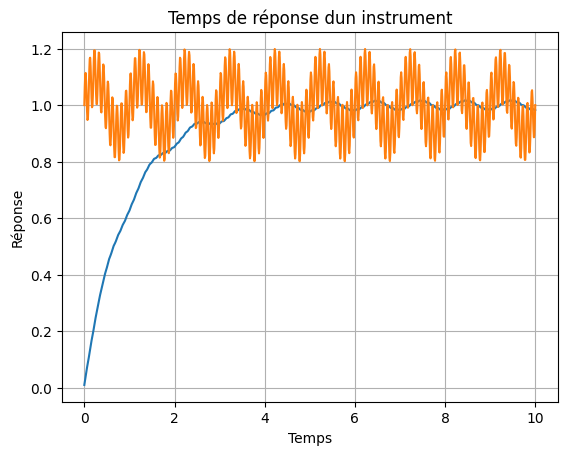

In [14]:

#| label: fig-bande-passante
#| fig-cap: "Un signal peut avoir un contenu fréquentiel que l'appareil ne peut pas reproduire. Le signal a une composante basse fréquence et une composante haute fréquence. La sortie de l'appareil ne reflète pas la haute fréquence. La basse fréquence est atténuée."
import numpy as np
import matplotlib.pyplot as plt
import control
from scipy import signal

# Define the transfer function
#numerator = [1]
#denominator = [1, 0.9, 1]  # Represents: s^2 + 2s + 1
#denominator = [0.1, 0.9]  # Represents: s^2 + 2s + 1
#system = control.TransferFunction(numerator, denominator)

# Define filter parameters
cutoff_frequency = 1  # Cutoff frequency in Hz

# Design the first-order low-pass filter
a=0.01
numerator = [a]
denominator = [1, a-1]
filter_system = signal.TransferFunction(numerator, denominator)

# Generate time values for simulation
U0=1;
DU1=0.1;
DU2=0.1;
time = np.linspace(0, 10, 1000)
U=np.sin(time*2*np.pi)*DU1+np.sin(time*20*np.pi)*DU2+U0
#U=np.concatenate([np.zeros_like(time[0:100]),np.ones_like(time[100:])])

# Simulate the step response
#time_response = control.step_response(system, time)
#time_response = control.forced_response(system, time, U, [U0,U0])
# Extract the time values and the system's response
#time_values = time_response[0]
#response = time_response[1]

response = signal.lfilter(numerator, denominator, U)

 
# Plot the step response
plt.plot(time, response)
plt.plot(time, U)
plt.xlabel('Temps')
plt.ylabel('Réponse')
plt.title('Temps de réponse d''un instrument')
plt.grid()
plt.show()


Régression Linéaire
-------------------

- Identification d'une réponse par plusieurs mesures
- Recherche des paramètres offset et gain de l'appareil
- Linéarisation de la caractéristique

Capteur idéal
-------------

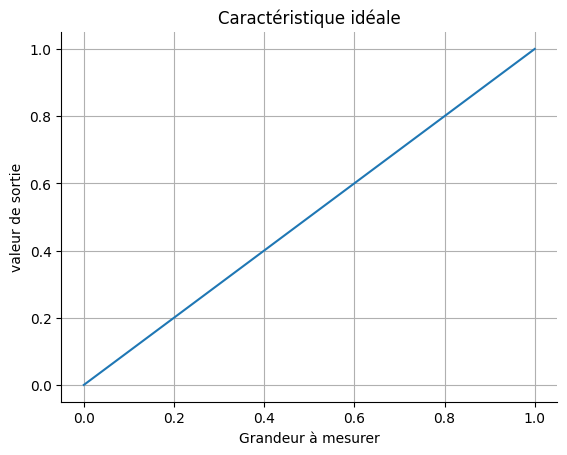

In [9]:
fig, ax = plt.subplots()
ax.plot([0, 1],[0, 1])
ax.set_xlabel("Grandeur à mesurer")
ax.set_ylabel("valeur de sortie")
ax.set_title("Caractéristique idéale")
ax.grid(True, which='both')

seaborn.despine(ax=ax, offset=0)

In [10]:
# Simulation de défauts sur un capteur
N=200
g0= 1 + np.random.rand()*0.1
o0= np.random.rand()*0.1
n0= 0.1;
res=[['random gain',g0],['random offset',o0],['noise gain',n0]]

rest=tabulate(res, tablefmt='html' )
display(HTML(rest))

random gain,1.01107
random offset,0.0585401
noise gain,0.1


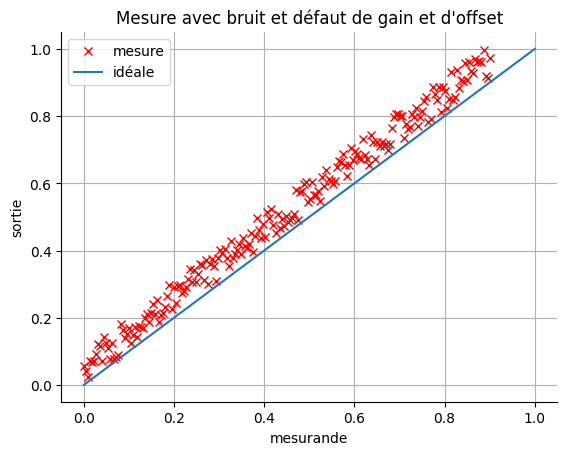

In [11]:
x = np.linspace(a[0], a[-1], N)
y = g0*x+o0+(np.random.rand(len(x))-0.5)*n0

fig, ax = plt.subplots()
ax.plot(x,y,'rx')
#ax.plot(x,o0+x*g0)
ax.plot([0,1],[0,1])
ax.set_xlabel("mesurande")
ax.set_ylabel("sortie")
ax.set_title("Mesure avec bruit et défaut de gain et d'offset")
ax.grid(True, which='both')
ax.legend(['mesure','idéale'])
seaborn.despine(ax=ax, offset=0)

In [12]:
# Identification de la caractéritique du capteur
model = LinearRegression()
xp=x.reshape((-1, 1))
tmp=model.fit(xp, y)
#r_sq = model.score(xp, y)
#print(f"coefficient of determination: {r_sq}")

In [13]:
display(HTML(tabulate([[f'N={N}','identification','valeurs réelles'],['gain',model.coef_, g0],['offset', model.intercept_,o0]], tablefmt='html', headers='firstrow')))

N=200,identification,valeurs réelles
gain,1.01773,1.01107
offset,0.0571389,0.0585401


In [14]:
y_pred=model.predict(xp)

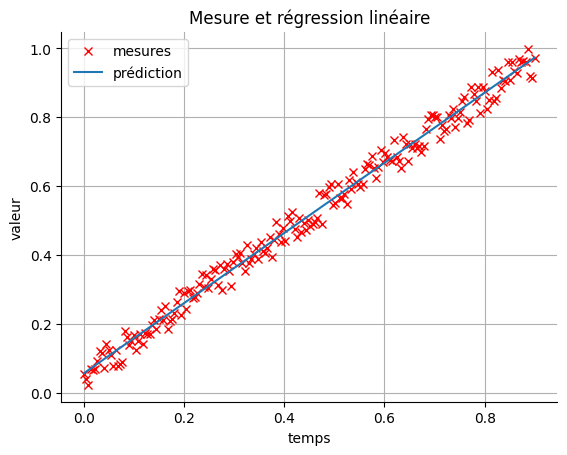

In [15]:
fig, ax = plt.subplots()
ax.plot(x,y,'rx')
ax.plot(x,y_pred)
ax.set_xlabel("temps")
ax.set_ylabel("valeur")
ax.set_title("Mesure et régression linéaire")
ax.grid(True, which='both')
ax.legend(['mesures','prédiction'])
seaborn.despine(ax=ax, offset=0)

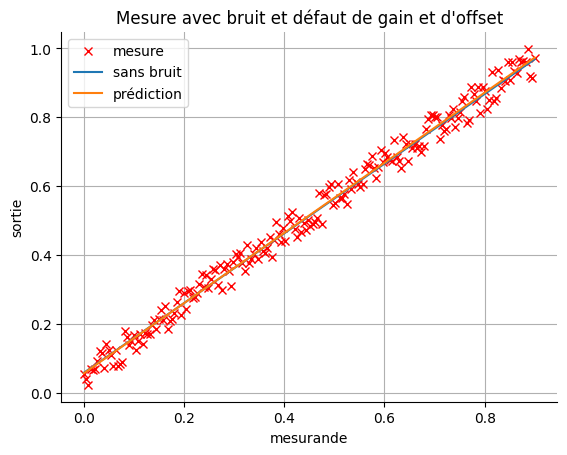

In [16]:
fig, ax = plt.subplots()
ax.plot(x,y,'rx')
ax.plot(x,o0+x*g0)
ax.plot(x,y_pred)
ax.set_xlabel("mesurande")
ax.set_ylabel("sortie")
ax.set_title("Mesure avec bruit et défaut de gain et d'offset")
ax.grid(True, which='both')
ax.legend(['mesure','sans bruit','prédiction'])
seaborn.despine(ax=ax, offset=0)

In [17]:
N

200

Fidélité d'un appareil
--------

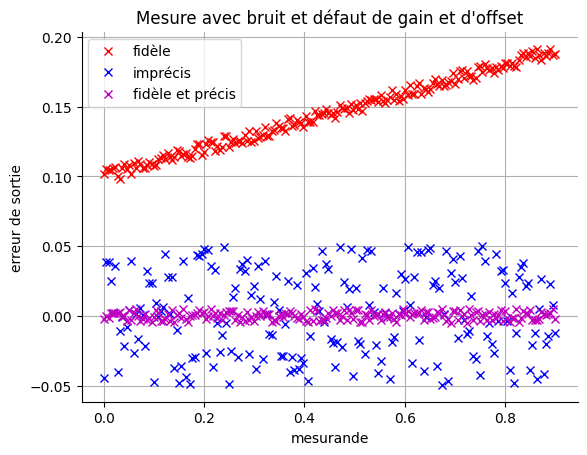

In [18]:
x = np.linspace(a[0], a[-1], N)
g0=1.1
o0=0.1
n0=0.01
y1 = g0*x+o0+(np.random.rand(len(x))-0.5)*n0

g0=1.0
o0=0.0
n0=0.1
y2 = g0*x+o0+(np.random.rand(len(x))-0.5)*n0

g0=1.0
o0=0.0
n0=0.01
y3 = g0*x+o0+(np.random.rand(len(x))-0.5)*n0

fig, ax = plt.subplots()
ax.plot(x,y1-x,'rx')
ax.plot(x,y2-x,'bx')
ax.plot(x,y3-x,'mx')

ax.set_xlabel("mesurande")
ax.set_ylabel("erreur de sortie")
ax.set_title("Mesure avec bruit et défaut de gain et d'offset")
ax.grid(True, which='both')
ax.legend(['fidèle','imprécis','fidèle et précis'])
seaborn.despine(ax=ax, offset=0)

# Thermorésistance, relation de Steinhart-Hart
----------------------------------------------

référence https://fr.wikipedia.org/wiki/Thermistance
https://fr.wikipedia.org/wiki/Relation_de_Steinhart-Hart

$$ {1 \over {T}} = A + B \ln(R_T) + C ( \ln(R_T))^3 $$

On peut simplifier pour une température connue à

$$ {R_T \over R_n} = \exp({\alpha_n \over 100 } \cdot T_n^2 \cdot ({1 \over T} - {1 \over T_n})) $$

In [19]:
def getT(RT):
    A= 0.0011268740732306604
    B= 0.00023452183442732656
    C= 8.590172470421073e-08
    return (A+B*np.log(RT)+C*np.log(RT)**3)**-1 - 273.15

In [20]:
getT(10)

326.39581494331503

In [21]:
RTr = np.arange(600,10000,1)
T=np.zeros(len(RTr))
for i in range(len(RTr)):
    T[i] = getT(RTr[i])

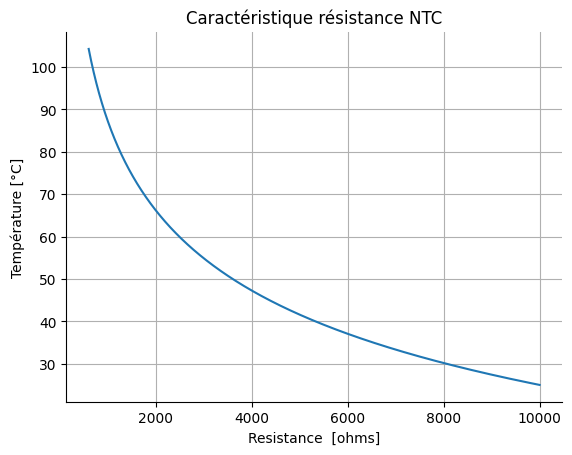

In [22]:
fig, ax = plt.subplots()
ax.plot(RTr, T)

ax.set_xlabel("Resistance  [ohms]")
ax.set_ylabel("Température [°C]")
ax.set_title("Caractéristique résistance NTC")
ax.grid(True, which='both')

seaborn.despine(ax=ax, offset=0)